# COMP9517: Computer Vision 2024 T3 Project Method: UDTransNet

#### z5499630 Hudson(Boyang) Peng


### Step 1: Clone the UDTransNet model from github

### We recommend running this project on Google Colab.

### The pretrained three model weights can be accessed by using this [Google Drive link](https://drive.google.com/file/d/1QuTORyzaZLMyP7VNFUPkaj-IbM9P3rur/view?usp=drive_link).

In [ ]:
!git clone https://github.com/McGregorWwww/UDTransNet.git

Cloning into 'UDTransNet'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 469 (delta 12), reused 3 (delta 0), pack-reused 440 (from 1)
Receiving objects: 100% (469/469), 126.27 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (38/38), done.


### Step 2: Install the required packages.


In [ ]:
%cd UDTransNet

/content/UDTransNet


In [ ]:
!pip install -r requirements.txt

In [16]:
!pip install tensorboardX
!pip install ml_collections

  Obtaining dependency information for tensorboardX from https://files.pythonhosted.org/packages/44/71/f3e7c9b2ab67e28c572ab4e9d5fa3499e0d252650f96d8a3a03e26677f53/tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00


### Step 3: Download the SeaTurtleID2022 dataset from kaggle

In [ ]:
!curl -L -o ./archive.zip https://www.kaggle.com/api/v1/datasets/download/wildlifedatasets/seaturtleid2022

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1682M  100 1682M    0     0  21.4M      0  0:01:18  0:01:18 --:--:-- 21.7M


In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: turtles-data/data/images/t217/JvHqeArYSk.JPG  
  inflating: turtles-data/data/images/t217/KAThYHNgIP.JPG  
  inflating: turtles-data/data/images/t217/KSOtTKQMjz.JPG  
  inflating: turtles-data/data/images/t217/KoYhgynvSp.JPG  
  inflating: turtles-data/data/images/t217/KpqGXYFZth.JPG  
  inflating: turtles-data/data/images/t217/KyvdAnjEAv.JPG  
  inflating: turtles-data/data/images/t217/LGAWMJSIJq.JPG  
  inflating: turtles-data/data/images/t217/LkbaMvGLKx.JPG  
  inflating: turtles-data/data/images/t217/MEPZlyZEoz.JPG  
  inflating: turtles-data/data/images/t217/MEyPcTKLOp.JPG  
  inflating: turtles-data/data/images/t217/MdsiRbEZQc.JPG  
  inflating: turtles-data/data/images/t217/MePRQQOVeR.JPG  
  inflating: turtles-data/data/images/t217/MprCwpdMYm.JPG  
  inflating: turtles-data/data/images/t217/NhQvIDPKSB.JPG  
  inflating: turtles-data/data/images/t217/NsCxjmKKXR.jpg  
  inflating: turtles-data/data/images/t217/NsMGqC

### Step 4: Generate masks of the dataset with areas in ['turtle', 'head', 'flippers']

### In this method, I need to partition the turtle into three distinct areas to perform binary segmentation over each area.


In [ ]:
%mv turtles-data/ ./datasets/
%cd ./datasets/turtles-data/data

/Users/hudson/Desktop/nibble/UNSW/24T3/COMP9517/proj/UDTransNet/datasets/turtles-data/data


In [ ]:
# Generate masked images with areas

from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd

# Choose one area to generate
# area = 'turtle'
area = 'head'
# area = 'flipper'

image_dir = ''
annotation_file = './annotations.json'
metadata_file = './metadata_splits.csv'
train_valid_folder_mask = f'./{area}_train_valid_folder_mask'
test_folder_mask = f'./{area}_test_folder_mask'

# Read the COCO styled annotation file
coco = COCO(annotation_file)

metadata = pd.read_csv(metadata_file)

# Get one category's ids e.g. "turtle"
category_ids = coco.getCatIds(catNms=[area])
image_ids = coco.getImgIds(catIds=category_ids)

Path(train_valid_folder_mask).mkdir(parents=True, exist_ok=True)
Path(test_folder_mask).mkdir(parents=True, exist_ok=True)

# 
def generate_and_save_mask(image_id):
    img_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, img_info['file_name'])

    image = Image.open(image_path)
    image = np.array(image)

    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=category_ids)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    split_label = metadata.loc[metadata['file_name'] == img_info['file_name'], 'split_closed'].values[0]

    mask_image = Image.fromarray(mask * 255)
    if split_label in ['train', 'valid']:
        mask_image.save(os.path.join(train_valid_folder_mask, f"{img_info['file_name'].split('/')[-1].split('.')[0]}_mask.png"))
    elif split_label == 'test':
        mask_image.save(os.path.join(test_folder_mask, f"{img_info['file_name'].split('/')[-1].split('.')[0]}_mask.png"))

for image_id in tqdm(image_ids, desc="Generating masks"):
    generate_and_save_mask(image_id)


loading annotations into memory...
Done (t=1.99s)
creating index...
index created!


Generating masks: 100%|██████████| 8628/8628 [05:31<00:00, 26.03it/s]


### Step 5: Divide all images into a training folder and a testing folder based on the 'split_closed' column in the CSV file.


In [ ]:
from pycocotools.coco import COCO
from pathlib import Path
import pandas as pd
import os
from tqdm import tqdm

# area = 'turtle'
area = 'head'
# area = 'flipper'

image_dir = '/content/UDTransNet/datasets/turtles-data/data'
annotation_file = '/content/UDTransNet/datasets/turtles-data/data/annotations.json'
metadata_file = '/content/UDTransNet/datasets/turtles-data/data/metadata_splits.csv'
train_valid_folder = f'/content/UDTransNet/datasets/turtles-data/data/{area}_train_valid_folder'
test_folder = f'/content/UDTransNet/datasets/turtles-data/data/{area}_test_folder'

coco = COCO(annotation_file)

metadata = pd.read_csv(metadata_file)

# Get one category's ids e.g. "turtle"
category_ids = coco.getCatIds(catNms=[area])
image_ids = coco.getImgIds(catIds=category_ids)

Path(train_valid_folder).mkdir(parents=True, exist_ok=True)
Path(test_folder).mkdir(parents=True, exist_ok=True)

# Go through all the ids of the image and split them into training folder or testing folder base on the split label
for image_id in tqdm(image_ids, desc="Processing images"):
    img_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, img_info['file_name'])

    if not os.path.exists(image_path):
        print(f"Image {image_path} not found. Skipping...")
        continue

    # Get all the annotation ids
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)
    
    # Check if the area was in the annotations
    if len(anns) > 0:
        # Get split label from the matadata_split.csv
        split_label = metadata.loc[metadata['file_name'] == img_info['file_name'], 'split_closed'].values

        if len(split_label) == 0:
            print(f"No metadata found for image {img_info['file_name']}. Skipping...")
            continue

        split_label = split_label[0]
        if split_label in ['train', 'valid']:
            target_folder = train_valid_folder
        elif split_label == 'test':
            target_folder = test_folder
        else:
            continue

        target_path = os.path.join(target_folder, os.path.basename(image_path))
        try:
            Path(target_path).write_bytes(Path(image_path).read_bytes())
            print(f"Copied {image_path} to {target_folder}")
        except Exception as e:
            print(f"Error copying {image_path}: {e}")
    else:
        print(f"Image {img_info['file_name']} does not contain '{area}' annotation. Skipping...")

loading annotations into memory...
Done (t=5.00s)
creating index...
index created!


Processing images:   0%|          | 0/8628 [00:00<?, ?it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t001/CAluWEgwPX.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t001/EKyrFKHQzh.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t001/ELAvEqeXxT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t001/IxRLFwTGCv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t001/LKCJAhfLBJ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t001/LZystXlIqe.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t001/OiaMESWPyh.JPG to /co

Processing images:   1%|▏         | 114/8628 [00:00<00:40, 209.22it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t003/tMOUElhljO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t003/zlkamyNHCP.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t004/ABuUaTxraz.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t004/BaeAeoSXhY.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t004/DBIYKSPapV.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t004/DJCSPZOvwy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:   3%|▎         | 220/8628 [00:00<00:24, 344.90it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t007/vOiTTqYJor.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t007/vUeJgjSgvr.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t007/vVOgPTtIBk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t007/vvijsBqKiM.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t007/woyemqnJnP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t007/zhfCTvDAyO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t007/zwhXVTh

Processing images:   4%|▍         | 328/8628 [00:00<00:19, 432.80it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t014/ihMILpMXhS.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t014/ildyupfVjO.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t014/jUvdVfamjr.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t014/myXSgZbtbV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t014/oKYSBlPEDo.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t014/oZdxIRrOXD.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:   5%|▌         | 435/8628 [00:01<00:17, 480.12it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t020/JrTfNUunFj.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t020/OUYzbRZIlf.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t020/RhZiDloeso.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t020/YaGEUDOxLU.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t020/aHVDbxNCsM.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t020/bOKksnxlvV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:   6%|▌         | 539/8628 [00:01<00:16, 486.29it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t023/oBndAkhCVa.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t023/pbbQhyoZgE.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t023/qmpVGJGnJQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t023/sXKQqnwTTb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t023/shXzdbiwef.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t023/tOOcZzuFnv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:   7%|▋         | 647/8628 [00:01<00:15, 509.58it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t028/aFqVrUCwyf.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t028/aQhnDQyJNZ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t028/aSHTwUcOdc.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t028/askIoCSXFD.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t028/bHoxlDQjKD.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t028/bULKcpcjhV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t028/

Processing images:   9%|▉         | 758/8628 [00:01<00:14, 532.51it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t033/gBETDKsWNA.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t033/gFeVhVsOfs.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t033/hieyMvTvor.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t033/jwjxRnRklT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t033/jywJyKJqHk.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t033/kVRsqEKXdU.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t033/kciAvlv

Processing images:  10%|█         | 872/8628 [00:01<00:14, 548.87it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t037/YLJUhRLaMo.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t037/aUkmhrWkvW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t037/bQRdTxEInM.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t037/bVODsWNSVI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t037/cNqHpXPAAA.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t037/dbeQtkcsZR.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t037/djfcaTI

Processing images:  11%|█▏        | 986/8628 [00:02<00:13, 556.85it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t043/GepjJmKxHz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t043/GqbarlIoDO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t043/IIGqpDYOAd.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t043/JFZqdyhhdg.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t043/JRGGZFGhLV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t043/PGyOTusSNl.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  13%|█▎        | 1098/8628 [00:02<00:13, 556.83it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t048/hzQgvtzVGz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t048/ipGWbzpTuk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t048/jSmmKNGooB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t048/joOJMFOVLD.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t048/jzAuTdIDMx.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t048/lQCDrndQJr.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t048/

Processing images:  14%|█▍        | 1213/8628 [00:02<00:13, 557.04it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t059/eQvGkMlFiW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t059/waTLbxjRoy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t059/yDHnTfvWPW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t060/AaUjYXPVOK.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t060/WsVFtFETtQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t060/jiyVbvrkGb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  15%|█▌        | 1328/8628 [00:02<00:13, 553.44it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t063/ymleSIxnRy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t063/zvHwUeVuNk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t064/BLhqoLEzAa.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t064/CauOUhofLb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t064/DISTYEABzX.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t064/GbqnmMBLua.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t064/

Processing images:  17%|█▋        | 1444/8628 [00:02<00:12, 563.48it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t068/eYYvhapSEW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t068/gkDdkIsCbI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t068/ibOTyqIxlP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t068/jjsrMISEhu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t068/kIxdRmIvTH.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t068/kUkMQtbKUJ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t068/pWJAXOUnAH.JPG

Processing images:  18%|█▊        | 1558/8628 [00:03<00:12, 555.06it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t074/rQCvSefSeB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t075/ABsMUmMvpa.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t075/AwDblCjcOR.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t075/BFgoBmtUki.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t075/DBeXbusGWL.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t075/FBKEiontAp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t075/FjvSfowVvL.JPG to /co

Processing images:  19%|█▉        | 1673/8628 [00:03<00:12, 563.16it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t081/FiqQzYSVzB.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t081/GiDdmUmPrx.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t081/Izqsevhivn.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t081/TFnSRontyN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t081/iEkQQoZjpW.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t082/FsHkMNbrFM.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t082/HHKuKUA

Processing images:  21%|██        | 1787/8628 [00:03<00:13, 496.23it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t092/jETTEoZxXf.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t092/kIHwlKLlOB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t092/mlnLNpNAbH.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t092/nhlPDoYGey.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t092/oQqZIclBzP.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t092/oRbVLKDrCI.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t092/oqtmmlM

Processing images:  22%|██▏       | 1905/8628 [00:03<00:12, 538.81it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/dhxVpJBWwn.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/eFzWQcWtbs.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/erBuGVTpgg.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/geKLJJYhpn.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/gqKRFOHOhj.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/iDYTjZdDnS.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  23%|██▎       | 2017/8628 [00:04<00:12, 540.55it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t102/SKTjfWyTjz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t102/TAEwjWusNx.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t102/WMZLFHXXjn.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t102/WRrrlTLlJy.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t102/WkzSZmcXho.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t102/XNGamOSGRB.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t102/Xpqv

Processing images:  25%|██▍       | 2128/8628 [00:04<00:11, 546.21it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t110/QinPuTyave.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t110/RuAZHTsnsX.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t110/RzaZSUBllI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t110/SOQyUayzxu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t110/THhtprWQNm.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t110/TSTPGcLtnf.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t110/

Processing images:  26%|██▌       | 2243/8628 [00:04<00:11, 560.37it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t119/wnNpinfSJT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t119/wydqILFvLd.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t119/zfHgHayeAa.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t120/pKGKUmGNUu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t120/saazeVLgDt.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t121/BOoeiOlEJV.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t121/BgdKvmj

Processing images:  27%|██▋       | 2359/8628 [00:04<00:11, 566.97it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t136/NlADChnHBl.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t136/PBqUQWkQhZ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t136/VkbmpAdDGI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t136/XFsNnfFGwb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t136/djSphRNPTq.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t136/dyfoMQhnoh.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t136/fwbGxOm

Processing images:  29%|██▊       | 2473/8628 [00:04<00:11, 554.47it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t141/jVtjeUqKLz.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t141/kEVnjaeNFu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t141/mgJrpCUero.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t141/nFyCadXWCH.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t141/pOHZEfooKL.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t141/pTcNYJUQOT.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t141/

Processing images:  30%|██▉       | 2585/8628 [00:05<00:11, 545.78it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t155/uknVXGVXBt.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t156/CQsKJfjxwu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t156/QVTyNEIBuS.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t156/eUXCctlAsQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t156/kuyGCNFWSM.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t156/kxGMFmQKMU.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  31%|███▏      | 2702/8628 [00:05<00:10, 561.70it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t160/QVOXmZTbDF.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t160/RKlhkwPIxT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t160/SmQjTXjtTQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t160/VcdARKlbLh.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t160/VuwrFlPRmM.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t160/YaULmPSgfZ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t160/

Processing images:  33%|███▎      | 2819/8628 [00:05<00:10, 570.88it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t166/geiQNiJFhV.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t166/irjeorvZCE.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t166/isOXDItGaS.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t166/lDXUsYccwR.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t166/nilgsGRDrX.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t166/plWgeKKHJi.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  34%|███▍      | 2936/8628 [00:05<00:09, 575.01it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t174/JMCwdlamRx.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t174/KPYnANucnI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t174/LYHqLwlOcs.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t174/LxPXFXtvbQ.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t174/PBcDLGqILc.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t174/QIVYfeOeDK.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  35%|███▌      | 3052/8628 [00:05<00:09, 576.21it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t184/pYlxhqnEmn.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t184/rVuZKKkmeM.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t184/tGsSnWaYTL.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t184/vtyfRcwGid.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t185/ERVbzfrhHz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t185/XxvfSNkxGw.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t185/ijZgxDB

Processing images:  37%|███▋      | 3169/8628 [00:06<00:09, 576.04it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t198/aQNZxzReZM.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t199/CToefapGST.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t199/ExMkUyfoDT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t199/NyknrUdkYI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t199/QNZCFSYusp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t199/YGPTUtKaOj.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  38%|███▊      | 3284/8628 [00:06<00:09, 558.86it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t202/IiWduSvFTY.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t202/MSERQfjfTk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t202/PPTUGiZGHt.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t202/QmySjZogxC.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t202/RaIhiJWqUT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t202/TuJwZZLkGy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  39%|███▉      | 3397/8628 [00:06<00:09, 556.07it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t204/gOWHWWDtHy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t204/gSTYnUIXXX.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t204/ggrGIwhdnK.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t204/gkGvSpXUBG.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t204/gxUdaNErru.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t204/heiRFoXEQn.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  41%|████      | 3509/8628 [00:06<00:09, 536.81it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t213/iRPXzbBxie.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t213/ivOHvQrAUt.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t213/iyIfjzdoos.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t213/kQWHoroTzv.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t213/mNpjCFcDCP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t213/mkDrlFWVup.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  42%|████▏     | 3617/8628 [00:06<00:09, 533.97it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t216/vdeawLuYBO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t216/xJimUuKfhh.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t216/xnVVDxgcvu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t216/ygeoXmwUPZ.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t216/yhVcyxRTvw.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t216/zALThbZnIW.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  43%|████▎     | 3727/8628 [00:07<00:09, 536.43it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t217/eXggwgczPQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t217/fHwpKpMQRo.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t217/fMgNqQJhef.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t217/fdLYkKTKCH.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t217/foUmlSIYFb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t217/ghUUQSaCit.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  44%|████▍     | 3837/8628 [00:07<00:08, 540.06it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t221/MqVwfWqmpq.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t221/NEESgTGseN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t221/NdRnLCkECr.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t221/NhaoikrDUD.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t221/OuxjuTDThh.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t221/QIXSgafIiy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  46%|████▌     | 3950/8628 [00:07<00:08, 548.98it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t225/oeOvmGDEWE.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t225/qbiKVGrTKL.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t225/sfuqUeCZGh.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t225/tnSyubBdIU.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t225/tybOhQksKB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t225/yBGXUYyLDT.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t225/

Processing images:  47%|████▋     | 4060/8628 [00:07<00:08, 546.38it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t230/rLoSuSjEkT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t230/vWljPLcXto.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t230/vjLQnILzBm.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t230/wYIRoqqNkF.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t230/wmMWXTLpgP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t230/xpmpdbwalt.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t230/

Processing images:  48%|████▊     | 4174/8628 [00:07<00:07, 558.16it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t232/yPQFcZalUk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t233/AIKfbWrsAW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t233/GUVPWHBWuc.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t233/SRTilRjnWg.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t233/UUFRJWMjXV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t233/YkCgttrJpf.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  50%|████▉     | 4288/8628 [00:08<00:07, 562.75it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t235/jjwZVULvek.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t235/kTPpQBfwlB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t235/kkCrlglHMl.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t235/ktcrxmWZiR.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t235/lAWvxZKjBw.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t235/lztqjlKzNW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/imag

Processing images:  50%|█████     | 4345/8628 [00:08<00:07, 553.70it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t237/FZDslyPOme.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t237/KFqCoKZpaA.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t237/LAimonXTKg.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t237/PolRZQwpvP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t237/PuVmAAbUAv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t237/PwRQaEnRQW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  52%|█████▏    | 4456/8628 [00:08<00:07, 547.11it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t241/SxzHCtPEqE.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t241/TqXpxRGlhk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t241/UYLejFUJHk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t241/UpPvAvBkEu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t241/VYNgIAQGgd.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t241/XyfzeqLgKZ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  53%|█████▎    | 4565/8628 [00:08<00:07, 509.02it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/QptLaqpyXx.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/RCaNUVTKRH.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/ROToctjYeO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/RaEOZkBSTF.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/RzwFEVrVHP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/SHtffWloeP.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t24

Processing images:  54%|█████▍    | 4668/8628 [00:08<00:08, 494.37it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/phhwekFmXA.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/qAxidCLTqH.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/qBmBjYQMyP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/qxOIHDWqFG.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/rAjWCHGNlV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t243/rVXIYAxMmu.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/imag

Processing images:  55%|█████▌    | 4776/8628 [00:09<00:07, 514.39it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t246/gNozlMwIGb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t246/hAhtmdfCkp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t246/imdrCiTnOk.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t246/itrmDXMAan.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t246/jqCwgoLcVW.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t246/mDLojXFVZA.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  57%|█████▋    | 4889/8628 [00:09<00:06, 539.27it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t251/cjrfHkHZjI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t251/dqpxtYGtco.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t251/fiaxGNFCzF.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t251/hFtBnQLidl.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t251/hTIFemwaie.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t251/hbNFLJUwul.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  58%|█████▊    | 4998/8628 [00:09<00:06, 527.20it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t257/jHXbxnNbgz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t257/jMrxspRwmc.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t257/jTjBibrLWu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t257/kWHZBkKjew.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t257/nloJNDWHet.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t257/oOAMWOBQNi.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  59%|█████▉    | 5113/8628 [00:09<00:06, 550.35it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t261/kSAebChOdT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t261/kzQMsHcaqT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t261/liHhnlIYdf.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t261/lvcYxmSUrT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t261/naIYDLRJWQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t261/oOEvCBABln.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  61%|██████    | 5230/8628 [00:09<00:06, 565.11it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t269/eZrbHnWrKv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t269/fIdEVvBIIp.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t269/lDRADaTtYo.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t269/pACzMCvBwr.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t269/qlTuFwvwAp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t269/sAmqBlAyGF.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  61%|██████▏   | 5287/8628 [00:09<00:05, 564.07it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t281/yUETlrBYAp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t281/ywfJTaZxGv.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t283/AfIShnJrXX.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t283/AnFJcEfdUb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t283/BKfKVkbgaC.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t283/BTWKQzeMiT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/imag

Processing images:  63%|██████▎   | 5397/8628 [00:11<00:25, 127.36it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t285/XNcaxFLRqy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t285/ZuuddFVBUy.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t285/dssMSCbBzn.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t285/eRqHUZXMXL.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t285/fIlBTapXlh.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t285/gwTCwavQyV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  64%|██████▍   | 5503/8628 [00:11<00:15, 204.80it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t292/sUWuqkCykS.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t292/tFjcpBYWAi.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t292/vvAGMYboHT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t292/vyEEJLvspT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t292/xrVGJfBqUb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t293/AgDkuFwWRv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  65%|██████▌   | 5621/8628 [00:12<00:09, 311.96it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t297/QIZMHzLEJL.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t297/gxHTYaaJFj.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t297/hVTICvMzZL.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t297/ijJZPUoDiU.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t297/kivAJmdZYQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t297/mucBYBaiJm.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  66%|██████▋   | 5732/8628 [00:12<00:07, 398.89it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t305/REYvlZzweB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t305/REmzOnpxFG.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t305/SEGNjtVtVu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t305/SKeNaIdNnl.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t305/THkzYwDoyK.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t305/TuGwmtWUSp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t305/

Processing images:  68%|██████▊   | 5851/8628 [00:12<00:05, 480.64it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t314/RjoolgCThP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t314/SuhcXdmKWN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t314/UMDrLasDBJ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t314/WvnRqoJOoU.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t314/ZZExipejqR.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t314/fTtbMeTqAN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t314/

Processing images:  69%|██████▉   | 5963/8628 [00:12<00:05, 499.93it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t321/QMgIXIfCbO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t321/TjYNVddUqK.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t321/oYKVPIkrOm.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t321/rayxKDwarv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t322/AaNTfozqoD.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t322/BSAuBxDiwT.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  70%|██████▉   | 6018/8628 [00:12<00:05, 503.99it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/McgrmDmyNw.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/NHBXNXQnLa.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/NMjKMbAAPS.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/NSrYfcoBkH.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/NZZoQvvTUo.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/NbNOtwPjZB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/OBSqwIQ

Processing images:  71%|███████   | 6127/8628 [00:13<00:04, 506.70it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/tpHAlunbgv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/uHFoeKhjxA.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/uKJqeIWumV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/uKTWankCWr.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/uRcxtwImey.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/ukIcsgnGkJ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t323/wPJEEwqHvy.JPG

Processing images:  72%|███████▏  | 6235/8628 [00:13<00:04, 515.35it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t331/ookQQYTjaY.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t331/sYcXhYmEex.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t331/yVYdnrNIPL.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t331/ywuIuUuFjZ.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t333/BjUuRTgGkp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t333/CKKfEtuvUP.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t333/EfQsCSXuez.

Processing images:  74%|███████▎  | 6346/8628 [00:13<00:04, 534.77it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t338/kZndorKkDf.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t338/mGmLGXMmhY.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t338/mQsBwBNgwv.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t338/qQAzyDniJv.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t338/qiKuOxsiix.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t338/wabbhTSuYN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t339/NJSqkQBPGR.JPG

Processing images:  75%|███████▍  | 6460/8628 [00:13<00:03, 545.02it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t351/DNVGbYwCQh.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t351/KOanhcvgvk.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t351/KPPfqUIiZx.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t351/NteUbimBmj.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t351/PGjZJRKQtI.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t351/QdFZJGHtJe.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  76%|███████▌  | 6573/8628 [00:13<00:03, 540.75it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t355/lteiWhiqWO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t355/srSmkOVGKb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t357/IgoCiUzsHb.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t357/IuSljCdnUz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t357/LSzMDJrbzo.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t357/NMFeJugxwQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/image

Processing images:  78%|███████▊  | 6690/8628 [00:14<00:03, 561.62it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t371/vgrrUpYpfV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t372/LdfNJFCpVS.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t372/MuLmstlRmK.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t372/TNhJufzUDw.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t372/VQEPJnBDbQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t372/bnRGUZajrV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  79%|███████▉  | 6808/8628 [00:14<00:03, 565.18it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t385/GRGPRpgDna.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t385/HZCqlsvSuN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t385/IEXDSKIKNS.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t385/IVERIkTcBS.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t385/NTMKJLVbmz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t385/TRdSEFLBTv.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  80%|████████  | 6924/8628 [00:14<00:02, 570.19it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t395/UXWyaOKnLu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t395/cLacqDNzyO.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t395/eHoRVBYHTB.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t395/sbQoaadfIz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t395/wWCoWeJinm.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t396/BlqNMnwcgD.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  82%|████████▏ | 7044/8628 [00:14<00:02, 581.60it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/ZdpClTSMme.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/aeJHMimrJF.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/antEGsAYEz.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/anvqsXMUpg.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/bLvCSEEPwi.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/bWRjocWUne.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  83%|████████▎ | 7163/8628 [00:14<00:02, 582.61it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t407/AdSoUugGAI.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t407/AhvUoRUbVM.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t407/ECEdPwPjbL.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t407/FNPQQKcXdk.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t407/HXcvdPuyJd.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t407/MKIQANgwqZ.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/imag

Processing images:  84%|████████▍ | 7280/8628 [00:15<00:02, 569.35it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t417/cDPEpRpRLU.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t417/dapmFhudud.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t417/ePyAMWqDVN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t417/fXQmoeapbV.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t417/gPpJfqocec.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t417/gTzChviNKD.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t417/hNrCqHS

Processing images:  86%|████████▌ | 7397/8628 [00:15<00:02, 576.27it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t427/qbzcrqRULr.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t427/rhDDlYQBNr.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t427/xDPYvvHDHD.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t429/CyTUVzsSxv.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t429/EcRLDrYiSL.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t429/FhRKTiSESK.jpg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  87%|████████▋ | 7513/8628 [00:15<00:01, 564.10it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t441/PAyPLlsXOC.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t441/PdZCVdSSvp.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t441/RBRkmGLbUO.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t441/ROLPWopGkC.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t441/RTMDADZvbN.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t441/RcjroHcoMn.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t441/SDoo

Processing images:  88%|████████▊ | 7627/8628 [00:15<00:01, 554.31it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t468/AHxkptpcqw.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t468/EibVMJyPYX.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t468/GaiQHCKfQN.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t468/HarlGKkPrA.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t468/ILbMyGfRev.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t468/IORtXLWXFg.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/dat

Processing images:  90%|████████▉ | 7746/8628 [00:16<00:01, 574.04it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t522/jNNpXHOYDu.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t522/jbPTvRHZOa.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t522/luKkdFCvvp.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t522/nVzHcOgdbQ.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t522/oLlbYueuac.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t522/ofVgzuaQSr.JPG to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/d

Processing images:  91%|█████████ | 7866/8628 [00:16<00:01, 585.48it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/eBWWjUpUwa.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/jGmuewrXQI.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/aPUsIpzHru.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/NzyNKqoOca.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/DAlVRCOXAu.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/SWtQCbddkC.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t095/cSWinIYxwO.jpeg to /co

Processing images:  93%|█████████▎| 7984/8628 [00:16<00:01, 585.10it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t295/uJKUqbMLqa.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t295/CaLVRRsKDU.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t295/DMTLCKoiUh.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t295/WJacrbiFZu.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t295/NsqOgkOIXX.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t295/WoSDILClcy.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t295/idHxeUppYG.jpeg to /co

Processing images:  94%|█████████▍| 8102/8628 [00:16<00:00, 571.42it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/bmYBPfhAQC.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/IjqMzahZYw.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/qTYTJEBXiI.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/BOvrDQIWDc.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/ByfSjvYayg.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t398/xttwXXCwMQ.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t421/MStvzVbsWZ.jpeg to /co

Processing images:  95%|█████████▌| 8219/8628 [00:16<00:00, 569.11it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t459/NjSenhkZpn.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t459/YnBrPxlDjt.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t459/rUZSWHueYE.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t459/iOHuUaZNtV.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t459/lGXEBmbCRI.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t459/aAFboMSSvO.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t459/ItzPeiUsYV.jpeg to /co

Processing images:  97%|█████████▋| 8341/8628 [00:17<00:00, 587.63it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/BETLlVHCRQ.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/ZHOFElHGnr.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/DUYSlRpoPm.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/CWDUgNfMNd.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/HEeShfiIIp.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t478/BhzSpyoqgc.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-da

Processing images:  98%|█████████▊| 8461/8628 [00:17<00:00, 580.23it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t527/kbkEELxyhr.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t527/osnQrYyAQi.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t527/tZVjxJkSDD.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t527/IploxTjbmh.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t528/FZQTbHtDmj.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t528/RmKTmoquXh.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t528/iFPAnbHu

Processing images:  99%|█████████▉| 8583/8628 [00:17<00:00, 587.44it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t584/ASRzxgdYSh.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t584/JCgcoHXoRG.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t584/auxWVFUApK.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t585/RqfqRcTZzE.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t585/BXrcgwLaMu.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t585/jsWvhVnUDA.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t585/c

Processing images: 100%|██████████| 8628/8628 [00:17<00:00, 492.51it/s]

Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/QRkXYgawZx.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/PZNmwPWMYh.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t474/HqzhRcdYCh.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t528/FRLmOIbNIc.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_train_valid_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t528/lADJAFFAjY.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t528/bbNjcWVPUS.jpeg to /content/UDTransNet/datasets/turtles-data/data/flipper_test_folder
Copied /content/UDTransNet/datasets/turtles-data/data/images/t528/twPQlKzlNa.jpeg

### Step 6: Create training and testing folders for the models

- The “img” folder in both training and testing folders is intended to store original images.
- The “labelcol” folder in both training and testing folders is intended to store masked ground truth images.

Then prepare the datasets in the following format for easy use of the code:
```text
├── datasets
│   ├── Turtle
│   │   ├── Test_Folder
│   │   │   ├── img
│   │   │   └── labelcol
│   │   └── Train_Folder
│   │       ├── img
│   │       └── labelcol
│   ├── Turtle_H
│   │   ├── Test_Folder
│   │   │   ├── img
│   │   │   └── labelcol
│   │   └── Train_Folder
│   │       ├── img
│   │       └── labelcol
│   └── Turtle_F
│       ├── Test_Folder
│       │   ├── img
│       │   └── labelcol
│       └── Train_Folder
│           ├── img
│           └── labelcol
```


### Move the split images into the corresponding folders as specified above


In [9]:
%cd datasets
%mkdir Turtle
%cd Turtle
%mkdir Test_Folder Train_Folder
%mkdir Test_Folder/img Test_Folder/labelcol
%mkdir Train_Folder/img Train_Folder/labelcol

[Errno 2] No such file or directory: 'datasets'
/Users/hudson/Desktop/nibble/UNSW/24T3/COMP9517/proj/UDTransNet/datasets/turtles-data/data
/Users/hudson/Desktop/nibble/UNSW/24T3/COMP9517/proj/UDTransNet/datasets/turtles-data/data/Turtle


In [ ]:
%cd /content/UDTransNet/datasets
%mkdir Turtle_H
%cd Turtle_H
%mkdir Test_Folder Train_Folder
%mkdir Test_Folder/img Test_Folder/labelcol
%mkdir Train_Folder/img Train_Folder/labelcol

/content/UDTransNet/datasets
/content/UDTransNet/datasets/Turtle_H


In [ ]:
%cd /content/UDTransNet/datasets
%mkdir Turtle_F
%cd Turtle_F
%mkdir Test_Folder Train_Folder
%mkdir Test_Folder/img Test_Folder/labelcol
%mkdir Train_Folder/img Train_Folder/labelcol

/content/UDTransNet/datasets
/content/UDTransNet/datasets/Turtle_F


### Step 7: Start the training

## IF YOU WANT TO TRAIN IT YOURSELF, PLEASE REPLACE THE `Config.py`, `Load_Dataset.py`, `test_kfold.py` AND `train_kfold.py` FILES IN THE CLONED PROJECT WITH OURS.

## ⚠️Please remember to rename the original image folder that was split into two parts to “img,” and rename the ground truth image (mask) to “labelcol.”⚠️

## ⚠️You must organize them in the structure showed in Step 6!⚠️

### The first step is to change the settings in `Config.py`, all the configurations including learning rate, batch size and etc. are in it.

We optimize the convolution parameters in U-Net and the DAT parameters together with a single loss. Run:

```bash
python train_kfold.py
```

The results including log files, model weights, etc., are in '[TaskName]_kfold' folder, e.g., 'Turtle_kfold'.

In [2]:
%cd /Users/hudson/Desktop/nibble/UNSW/24T3/COMP9517/proj/UDTransNet

/Users/hudson/Desktop/nibble/UNSW/24T3/COMP9517/proj/UDTransNet


In [ ]:
!python train_kfold.py

Streaming output truncated to the last 5000 lines.
   [Train] Fold: [2/5] Epoch: [16][132/151]  Loss:0.267 (Avg 0.2411) Dice:0.8575 (Avg 0.8185) LR 9.90e-04   (AvgTime 0.5)   
   [Train] Fold: [2/5] Epoch: [16][133/151]  Loss:0.192 (Avg 0.2407) Dice:0.8513 (Avg 0.8187) LR 9.90e-04   (AvgTime 0.5)   
   [Train] Fold: [2/5] Epoch: [16][134/151]  Loss:0.317 (Avg 0.2413) Dice:0.7567 (Avg 0.8183) LR 9.90e-04   (AvgTime 0.5)   
   [Train] Fold: [2/5] Epoch: [16][135/151]  Loss:0.324 (Avg 0.2419) Dice:0.7585 (Avg 0.8178) LR 9.90e-04   (AvgTime 0.5)   
   [Train] Fold: [2/5] Epoch: [16][136/151]  Loss:0.278 (Avg 0.2422) Dice:0.7750 (Avg 0.8175) LR 9.90e-04   (AvgTime 0.5)   
   [Train] Fold: [2/5] Epoch: [16][137/151]  Loss:0.276 (Avg 0.2424) Dice:0.8144 (Avg 0.8175) LR 9.90e-04   (AvgTime 0.5)   
   [Train] Fold: [2/5] Epoch: [16][138/151]  Loss:0.306 (Avg 0.2429) Dice:0.7684 (Avg 0.8171) LR 9.90e-04   (AvgTime 0.5)   
   [Train] Fold: [2/5] Epoch: [16][139/151]  Loss:0.227 (Avg 0.2428) Dice:

### Step 8: Start Testing

### !! First, change the session name in `Config.py` as the training phase. !!

### IF YOU ARE USING OUR PRE-TRAINED WEIGHT. 
### PUT THE MODEL TRAINED FOR `FLIPPERS` IN `Turtle_F_kfold/UDTransNet/Test_session_10.26_10h23/models/fold_1`
### PLEASE USE 'Test_session_10.26_10h23' for Flippers
### PUT THE MODEL TRAINED FOR `HEAD` IN `Turtle_H_kfold/UDTransNet/Test_session_10.25_05h19/models/fold_1`
### PLEASE USE 'Test_session_10.25_05h19' for Head
### PUT THE MODEL TRAINED FOR `CARAPACE` IN `Turtle_kfold/UDTransNet/Test_session_10.25_00h25/models/fold_1`
### PLEASE USE 'Test_session_10.25_00h25' for Carapace

Then, for Turtle, Turtle_H and Turtle_F, run:

```bash
python test_kfold.py
```

### You can get the Dice and IoU scores and the visualization results `in the visualized folder`

In [ ]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 40.0 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762840 sha256=ff4ade2fa5087b9b1bacb08cdfee651a1de71a21e18cc9af145a8457b51014a7
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [5]:
!python test_kfold.py

10 Turtle
Model loaded !
==== 1 models loaded ====
Test visualize: 100%|████████████████| 10/10 [00:02<00:00,  3.49img/s]
inference_time 0.2883608818054199
dice_5folds: [97.19]
iou_5folds: [94.68]
dice: 97.19+nan
iou: 94.68+nan


### Segmentation Results visualized

### You can get the Dice and IoU scores and the visualization results `in the visualized folder`

### Here is the table containing all the results from three parts
| Metrics   | Head  | Carapace | Flippers | 
|-|-|-|-|
|**DICE**|`88.50%`|`97.41%`|`89.47%`|
|**mIoU**|`81.48%`|`95.31%`|`82.43%`|

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_folder = "./Turtle_visualize_test"
image_folder_F = "./Turtle_F_visualize_test"
image_folder_H = "./Turtle_H_visualize_test"

image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
image_files_F = sorted([f for f in os.listdir(image_folder_F) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
image_files_H = sorted([f for f in os.listdir(image_folder_H) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])


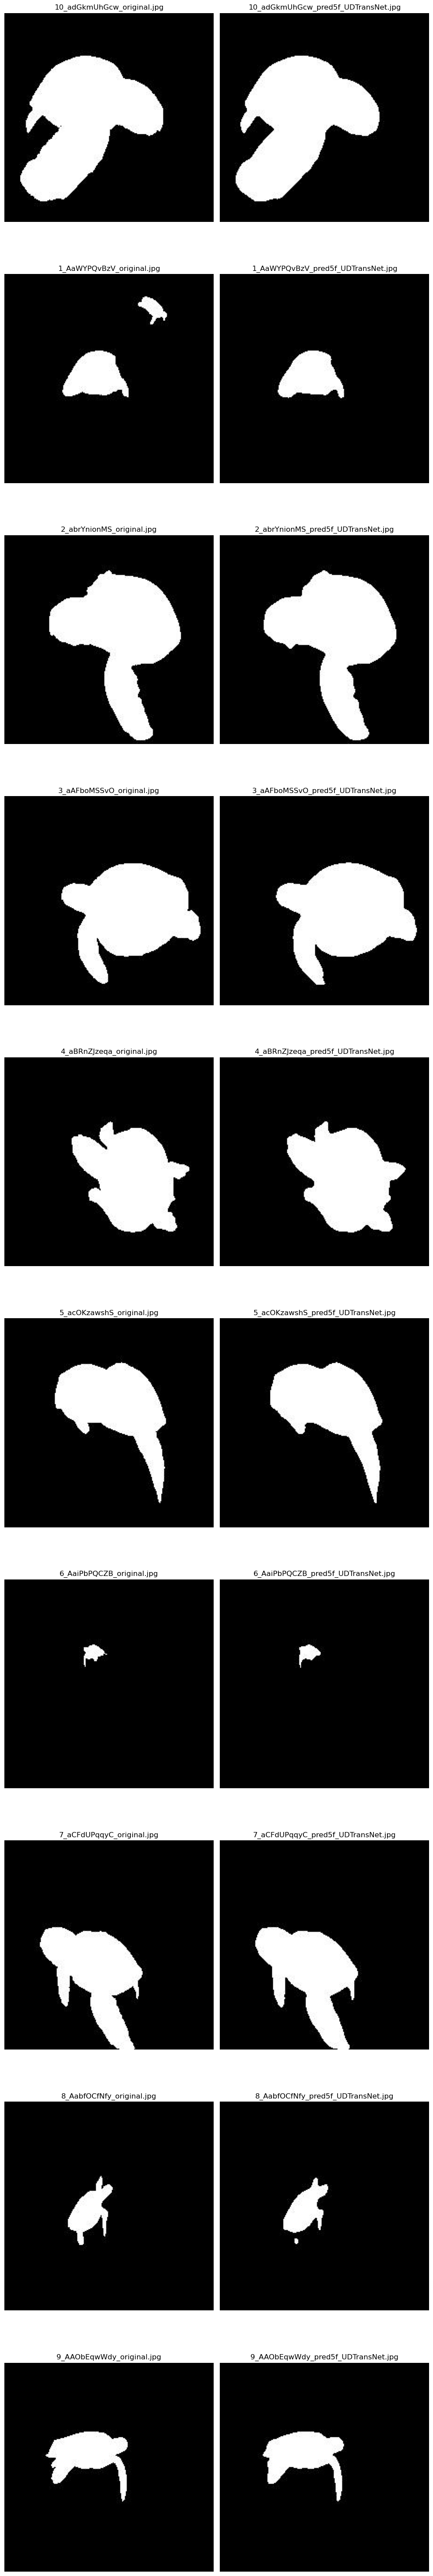

In [8]:

# Print all segmented Carapace
if not image_files:
    print("No images in this folder!")
else:
    plt.figure(figsize=(10, len(image_files) * 3))

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        
        plt.subplot(len(image_files) // 2 + len(image_files) % 2, 2, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_file)
    
    plt.tight_layout()
    plt.show()


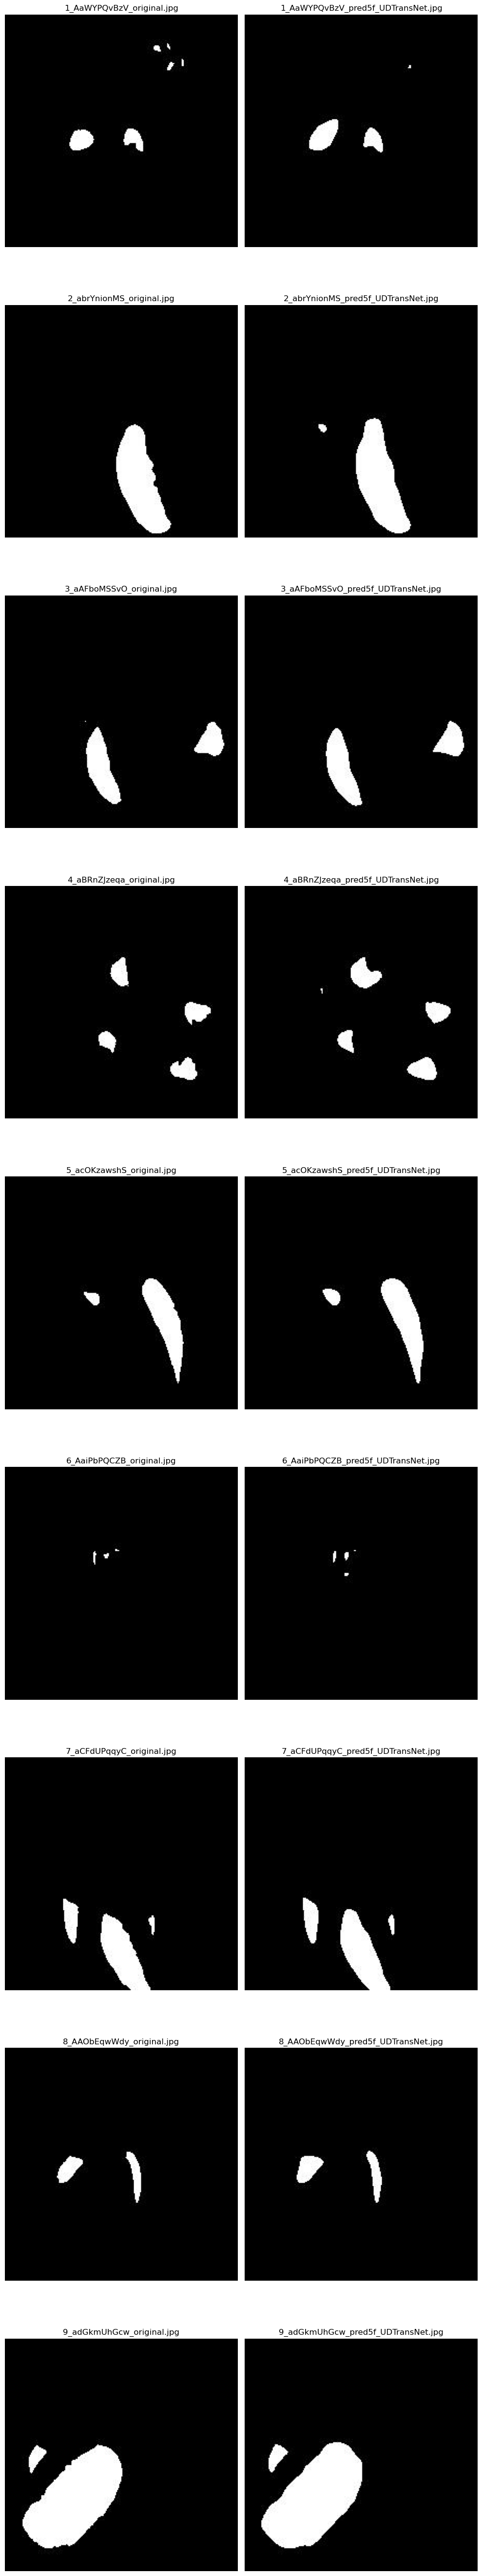

In [9]:
# Print all segmented Flippers
if not image_files_F:
    print("No images in this folder!")
else:
    plt.figure(figsize=(10, len(image_files_F) * 3))

    for i, image_file in enumerate(image_files_F):
        image_path = os.path.join(image_folder_F, image_file)
        image = Image.open(image_path)
        
        plt.subplot(len(image_files_F) // 2 + len(image_files_F) % 2, 2, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_file)
    
    plt.tight_layout()
    plt.show()

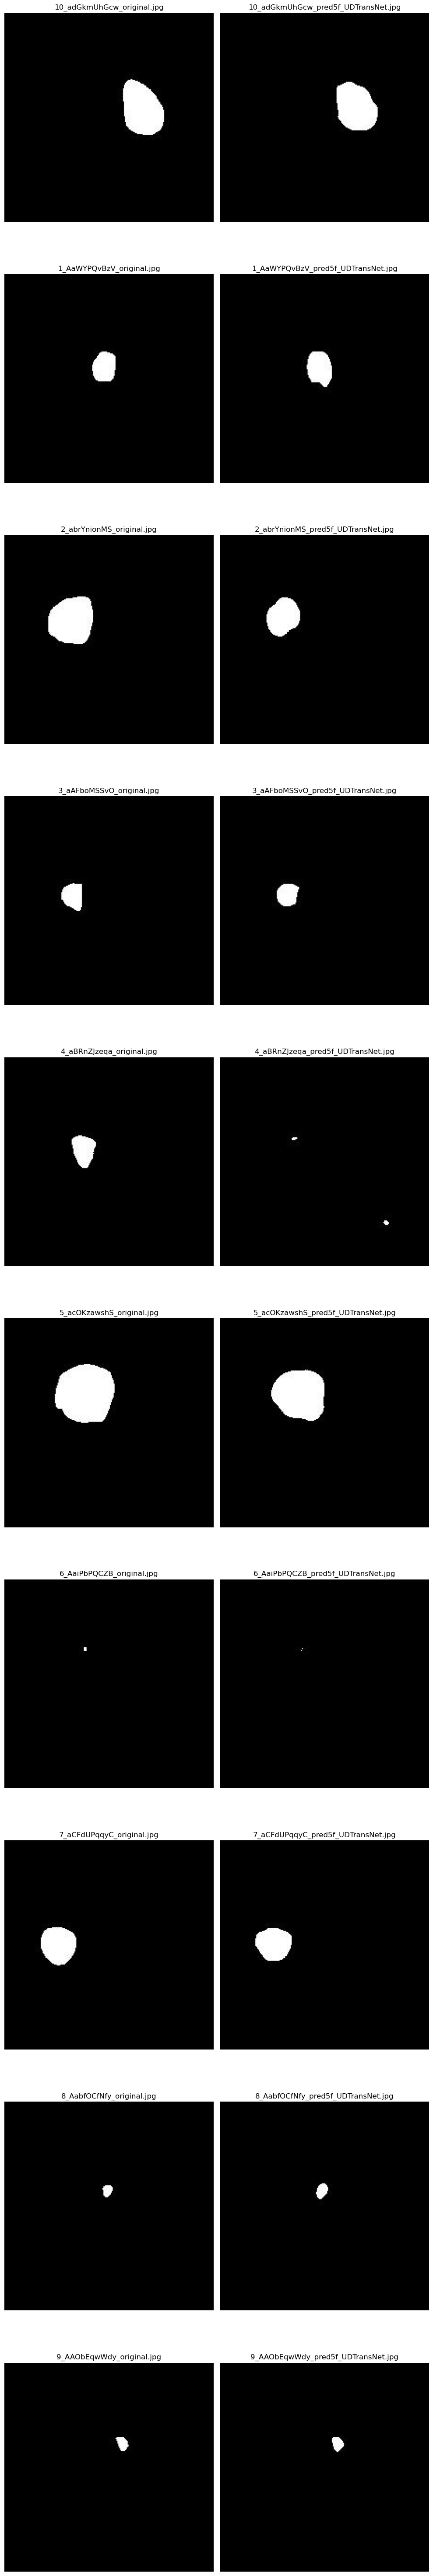

In [19]:
# Print all segmented Head
if not image_files_H:
    print("No images in this folder!")
else:
    plt.figure(figsize=(10, len(image_files_H) * 3))

    for i, image_file in enumerate(image_files_H):
        image_path = os.path.join(image_folder_H, image_file)
        image = Image.open(image_path)
        
        plt.subplot(len(image_files_H) // 2 + len(image_files_H) % 2, 2, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_file)
    
    plt.tight_layout()
    plt.show()